# 6.6 - Sourcing and Analyzing Time Series Data

## Script Contents:

#### 1. Importing libraries and data

#### 2. Subsetting, wrangling, and cleaning time-series data

#### 3. Time series analysis: decomposition

#### 4. Testing for stationarity

#### 5. Stationarizing the Austin Airbnb Data

### 1. Importing libraries and data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight')

In [2]:
%matplotlib inline

In [3]:
#Setting path to Achievement 6 master folder
path = r'/Users/jeremyobach/Documents/Data Analytics/CareerFoundry/Achievement 6 - Self Designed Project/Austin Airbnb Project - MASTER FOLDER'
#checking path set correctly
path

'/Users/jeremyobach/Documents/Data Analytics/CareerFoundry/Achievement 6 - Self Designed Project/Austin Airbnb Project - MASTER FOLDER'

In [4]:
# delimiting columns displayed
pd.options.display.max_columns = None

In [5]:
# Importing data from Inside Airbnb 2023 Scrape - Summary info and metrics for listings

listings = pd.read_csv(os.path.join(path,'02 Data', 'Inside Airbnb', 'Dec 23 data', 'Austin.dec23.summary.listings.csv'), index_col = False)

In [6]:
listings.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,5456,Guesthouse in Austin · ★4.84 · 1 bedroom · 2 b...,8028,Sylvia,NaN,78702,30.26057,-97.73441,Entire home/apt,101.0,2,668,2023-11-20,3.71,1,330,47,NaN
1,5769,Home in Austin · ★4.91 · 1 bedroom · 1 bed · 1...,8186,Elizabeth,NaN,78729,30.45697,-97.78422,Private room,NaN,1,294,2023-12-07,1.76,1,0,20,NaN
2,218402,Home in Austin · ★4.74 · 1 bedroom · 1 bed · 1...,1129520,Paulette,NaN,78754,30.36145,-97.64397,Private room,30.0,28,29,2023-09-24,0.20,1,252,2,NaN
3,6413,Guesthouse in Austin · ★4.97 · Studio · 1 bed ...,13879,Todd,NaN,78704,30.24885,-97.73587,Entire home/apt,NaN,30,120,2022-10-17,0.70,1,0,0,NaN
4,6448,Guesthouse in Austin · ★4.97 · 1 bedroom · 2 b...,14156,Amy,NaN,78704,30.26034,-97.76487,Entire home/apt,159.0,3,312,2023-12-04,2.09,1,160,21,NaN


In [7]:
reviews = pd.read_csv(os.path.join(path,'02 Data', 'Inside Airbnb', 'Dec 23 data', 'Austin.dec23.summary.reviews.csv'), index_col = False)

In [8]:
reviews.shape

(586441, 2)

In [9]:
reviews.head(25)

,listing_id,date
0,5456,2009-03-08
1,5456,2009-03-19
2,5456,2009-03-22
3,5456,2009-04-08
4,5456,2009-04-13
5,5456,2009-04-16
6,5456,2009-04-20
7,5456,2009-04-26
8,5456,2009-05-11
9,5456,2009-05-19


In [10]:
reviews.columns

Index(['listing_id', 'date'], dtype='object')

In [11]:
type(reviews)

pandas.core.frame.DataFrame

### 2. Subsetting, wrangling, and cleaning time-series data

In [13]:
# Set the "Date" column as the index

from datetime import datetime

reviews['datetime'] = pd.to_datetime(reviews['date']) # Create a datetime column from "date.""
reviews = reviews.set_index('datetime') # Set the datetime as the index of the dataframe.
reviews.drop(['date'], axis=1, inplace=True) # Drop the "Date" column.
reviews.head()

,listing_id
datetime,
2009-03-08,5456
2009-03-19,5456
2009-03-22,5456
2009-04-08,5456
2009-04-13,5456


### Visualizing reviews per Quarter first, then Reviews per Month:

In [16]:
# Group by quarter and count the number of reviews
quarterly_reviews = reviews.groupby(pd.Grouper(freq='Q')).size()

In [17]:
# Create a new DataFrame with quarter and corresponding number of reviews
quarterly_reviews_df = pd.DataFrame({'Quarter': quarterly_reviews.index, 'Reviews': quarterly_reviews.values})

In [18]:
# Set 'Quarter' column as the index
quarterly_reviews_df.set_index('Quarter', inplace=True)

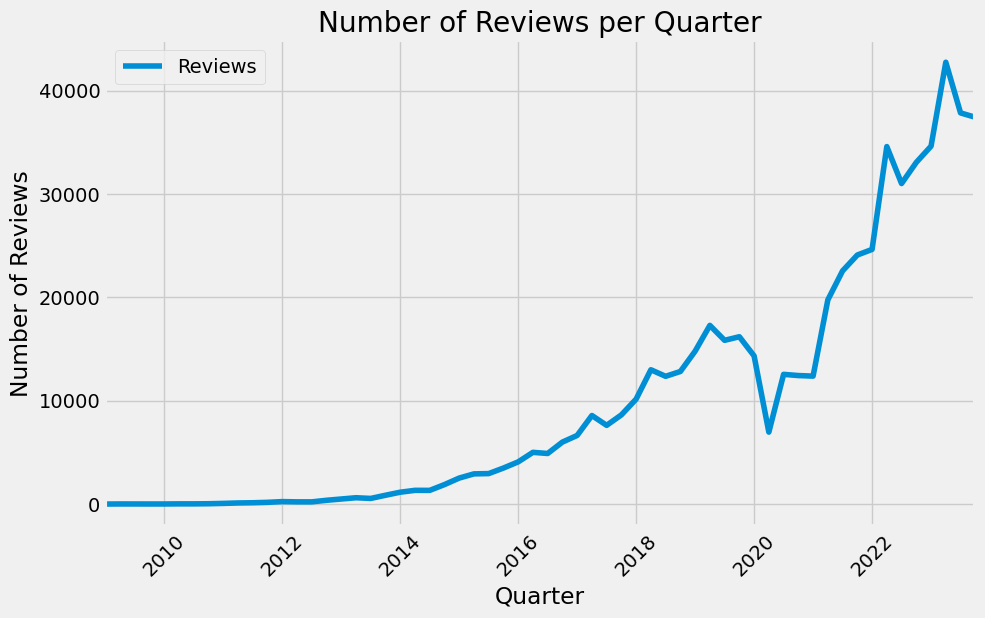

In [19]:
# Plot the data
quarterly_reviews_df.plot(kind='line', figsize=(10, 6))
plt.title('Number of Reviews per Quarter')
plt.xlabel('Quarter')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()

In [20]:
# Checking for missing values

quarterly_reviews_df.isnull().sum()

# no missing values

Reviews    0
dtype: int64

In [21]:
# Checking for duplicates

dups = quarterly_reviews_df.duplicated()
dups.sum()

# No duplicates

1

### Getting Reviews Per Month:

In [23]:
# Group by month and count the number of reviews

monthly_reviews = reviews.groupby(pd.Grouper(freq='M')).size()

In [24]:
# Create a new DataFrame with month and corresponding number of reviews

monthly_reviews_df = pd.DataFrame({'Month': monthly_reviews.index, 'Reviews': monthly_reviews.values})

In [25]:
# Saving a version of monthly_reviews where Month Column not index
monthly_reviews = pd.DataFrame({'Month': monthly_reviews.index, 'Reviews': monthly_reviews.values})

In [26]:
# Set 'Month' column as the index
monthly_reviews_df.set_index('Month', inplace=True)

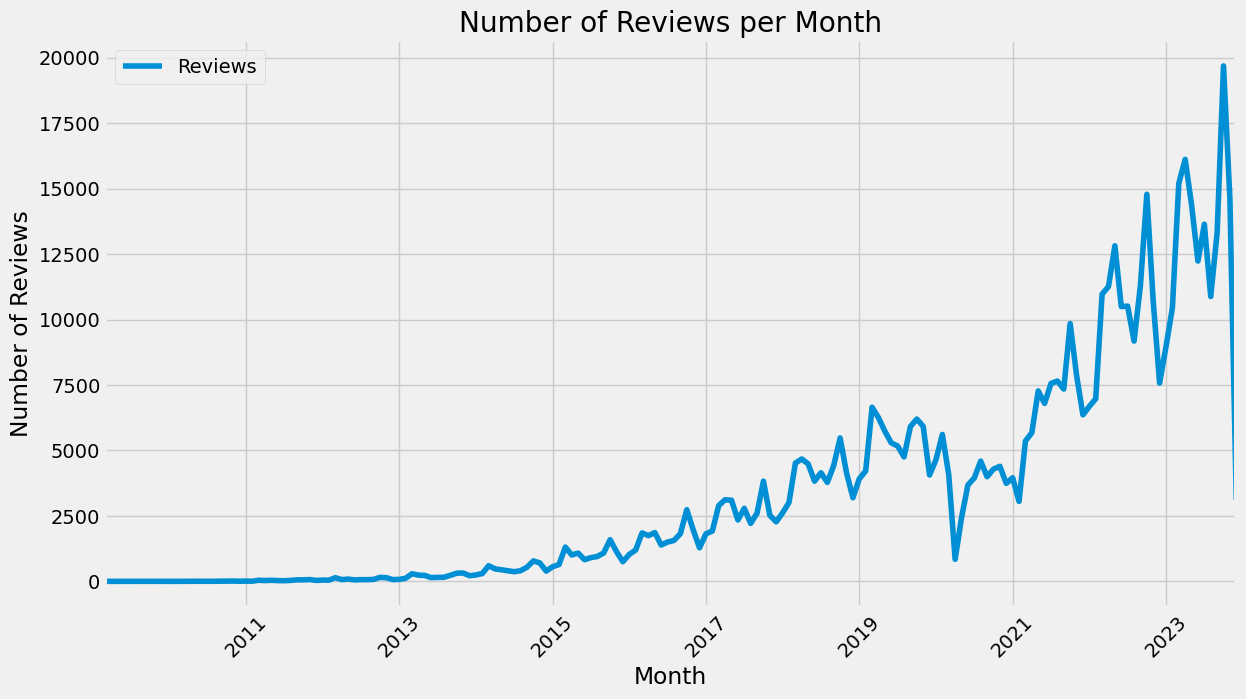

In [27]:
# Plot the data
monthly_reviews_df.plot(kind='line', figsize=(13, 7))
plt.title('Number of Reviews per Month')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'reviews_per_month.png'))
plt.show()

In [ ]:
monthly_reviews.shape

In [ ]:
monthly_reviews_df.to_csv(os.path.join(path,'02 Data', 'Prepared Data','monthly_reviews_timeseries.csv'))

### 3. Time-series analysis: decomposition

In [ ]:
# decomposing reviews per month time series using an multiplicative model

decomposition = sm.tsa.seasonal_decompose(monthly_reviews_df, model='additive')

# try multiplicative and additive

In [ ]:
from pylab import rcParams ## This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 10

In [ ]:
# Plot the separate components

decomposition.plot()
plt.show()

### 4. Testing for stationarity

* The adfuller() function will import from the model from statsmodels for the test; however, running it will only return an array of numbers. This is why you need to also define a function that prints the correct output from that array.

In [ ]:
from statsmodels.tsa.stattools import adfuller 

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(monthly_reviews_df['Reviews'])

Test statistic is larger than all critical values -> can't reject the null hypothesis -> there *is* a unit root in the data -> data is non-stationary -> data has a trend

In [ ]:
# Plot of autocorrelations; alternative check for stationarity

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(monthly_reviews_df)
plt.show()

# lines going above the blue area (confidence interval) are lags.
# Many lags -> autocorrelated data, non-stationary dataset

### 5. Stationarizing Austin Airbnb Reviews Data

In [ ]:
data_diff = monthly_reviews_df - monthly_reviews_df.shift(1)

The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [ ]:
data_diff.dropna(inplace = True)

In [ ]:
data_diff_cutoff = data_diff[: '2023-12-23']

 Here, we remove the missing values that came about as a result of the differencing. 
We need to remove these or we won't be able to run the Dickey-Fuller test.

In [ ]:
data_diff.columns

In [ ]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_cutoff)

In [ ]:
dickey_fuller(data_diff)

#### Test statistic is still *slightly* larger than critical values, p value still > 0.05. -> Dataset still not stationary

In [ ]:
plot_acf(data_diff_cutoff)
plt.show()

# Looks like all but two lines are unaccounted for, but 1 is massively unaccounted for.

### Another round of differencing:

In [ ]:
data_diff_2 = data_diff_cutoff - data_diff_cutoff.shift(1)

In [ ]:
data_diff_2.dropna(inplace = True)

In [ ]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_2)

In [ ]:
dickey_fuller(data_diff_2)

Test statistic smaller than all critical values. P-value is miniscule, much lower than 0.05.

In [ ]:
plot_acf(data_diff_2)
plt.show()

Autocorrelations about the same as before second round of differencing.